# lab_03 - Biblioteka Dask. Część 2.

## 1. Dask Bags.

Struktura danych Dask Bag (z angielskiego torba, worek) została stworzona po to, aby na wysokim poziomie abstrakcji oraz, właściwie przede wszystkim, możliwe było wykonanie operacji na wielu obiektach Pythona w sposób rozproszony. Dask Bag implementuje między innymi takie metody jak `map, filter, groupby` i jest podobny w działaniu do zrównoleglonej wersji modułu itertools oraz sposobu w jaki działa PySpark RDD (Spark'owa wersja rozproszonych ramek danych).

> **Dokumentacja API Dask Bag:** https://docs.dask.org/en/latest/bag-api.html

In [1]:
from dask.distributed import Client, progress

client = Client(n_workers=4)

In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57936,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.91 GiB
Comm: tcp://127.0.0.1:57962,Total threads: 3
Dashboard: http://127.0.0.1:57968/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:57939,


In [4]:
import dask
import json
import os

# zmienna ze ścieżką do folderu, w którym będą składowane dane
DATAPATH = './data/json'

# tworzymy FOLDERY jeżeli wymagane jest stworzenie całej ścieżki folderów, jeżeli istnieje nie nadpisze
os.makedirs(DATAPATH, exist_ok=True)

In [ ]:
# jeżeli brakuje modułu mimesis
!pip install mimesis

In [ ]:
%%time
# wykorzystujemy wbudowaną metodę generującą dane dla określonej liczby partycji oraz ilości rekordów per partycja (plik)
# szczegóły implementacji tej metody znajdziemy pod adresem https://docs.dask.org/en/stable/_modules/dask/datasets.html
# wymagane będzie zainstalowanie modułu mimesis
# tworzymy Dask Bag danymi, zmień parametry na coś, co będzie Ci odpowiadało bardziej (np. bardzo duża liczba małych plików lub mniejsza liczba plików, ale więcej wierszy w każdym)

b = dask.datasets.make_people(npartitions=100, records_per_partition=10000)
# po wykonaniu operacji 10000 rekordów zajmuje około 2.4 MB, co razem daje około 240 MB
# można więc z powodzeniem dla zadania Dask'owi większej ilości pracy, zwiększyć te parametry kilkukrotnie

# wykorzystujemy metodę map do wykonania json.dumps na każdym elemencie zawartym w Bag (a jak prześledzimy źródła to jest to słownik krotek)
# następnie wykonujemy metode to_textfiles() z API Dask Bag i zapisujemyy każdą partition do oddzielnego pliku JSON
# operacje te wykonają się w sposób zrównoleglony (na ile to możliwe, gdyż dane ostatcznie zapisujemy w jednym miejscu na dysku)

b.map(json.dumps).to_textfiles(os.path.join(DATAPATH, '*.json'))

In [11]:
# korzystamy z polecenia head, które wyświetla n pierwszych linii z zadanego pliku, tu n=2
!head -n 2 ./data/json/00.json

{"age": 67, "name": ["Florentina", "Swanson"], "occupation": "Merchant", "telephone": "+19100456623", "address": {"address": "1085 Lilac Ferry", "city": "West Jordan"}, "credit-card": {"number": "3729 416107 99053", "expiration-date": "05/22"}}
{"age": 38, "name": ["Edra", "Warner"], "occupation": "Video Artist", "telephone": "+1-480-554-1266", "address": {"address": "1311 Jeopardy Creek", "city": "Los Altos"}, "credit-card": {"number": "5543 2823 9962 9366", "expiration-date": "10/20"}}


In [12]:
import dask.bag as db
import dask.dataframe as dd
import json

# ponownie wykorzystujemy metodę map (tym razem mapujemy json.loads) na każdym pliku w folderze
b = db.read_text(os.path.join(DATAPATH, '*.json')).map(json.loads)
# graf obliczeniowy został przygotowany, ale obliczenia jeszcze się nie wykonały
b

dask.bag<loads, npartitions=100>

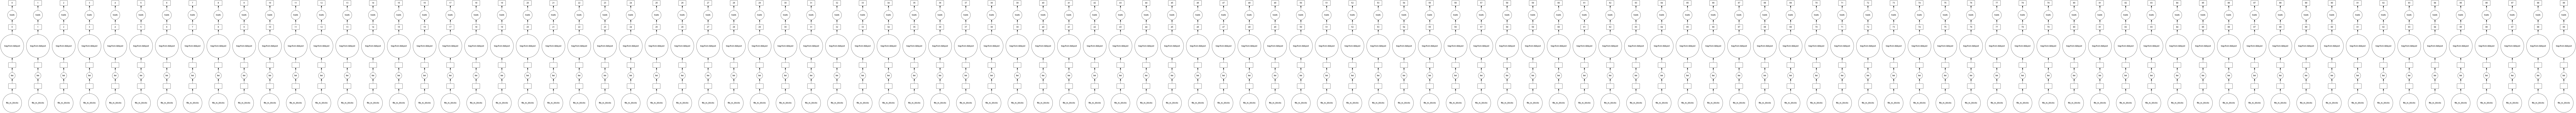

In [13]:
b.visualize()

In [14]:
# policzmy teraz ile jest osób pełnoletnich
count_adults = b.filter(lambda record: record['age'] >= 18).count().compute()

In [15]:
count_adults

850947

In [ ]:
# poprzez metodę map możemy również dobrać tylko wybrane wartości rekordu (nasz rekord to słownik)
# dalej zliczamy częstość wartości dla cechy occupation. UWAGA, wynik może składać się z wielu wartości.
occupations_counts = b.map(lambda record: record['occupation']).frequencies(sort=True).compute()
occupations_counts

In [17]:
adults = b.filter(lambda record: record['age'] >= 18)
adults

dask.bag<filter-lambda, npartitions=100>

## 2. Dask delayed.

Czasami wykorzystanie samych struktur danych, które dostarcza dask może nie wystarczyć, aby współbieżnie wykonać jakieś zadania. Dzięki dask delayed możliwe jest zrównoleglanie wykonania własnego kodu, co pozwala na optymalizowanie bardziej złożonych zadań w mniejsze fragmenty, które można przekazać do wykonania do klastra dask.

Poniższy przykład wykorzystania dask delayed pochodzi z dokumentacji dask dostępnej pod adresem: https://docs.dask.org/en/latest/delayed.html

In [18]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

In [19]:
output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

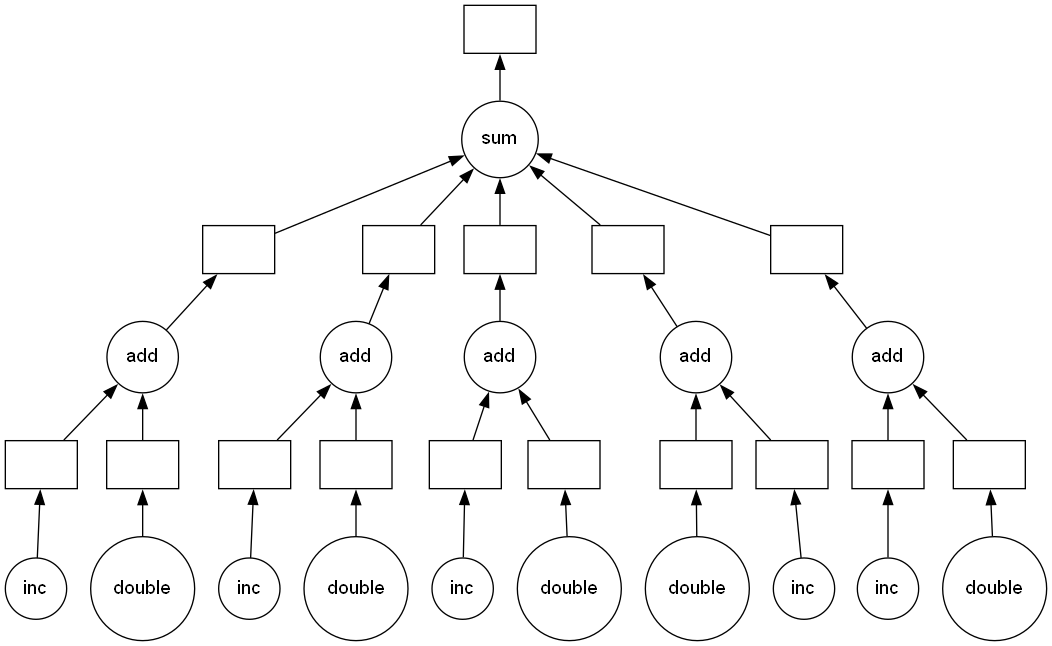

In [20]:
total.visualize()

In [22]:
total.compute()

50

Widać tutaj, że dwie pierwsze operacje mogą być wywołane niezależnie gdyż polegają na przetworzeniu listy `x` dwiema niezależnymi funkcjami (`inc` oraz `double`), więc można je wykonać równolegle. Późniejsza operacja `add` musi już być wykonana po wykonaniu wcześniejszych obliczeń, ale dzieląc wcześniej listę `x` na fragmenty również można rozbić to zadanie na wiele mniejszych i zrównoleglić. Finalnie potrzebujemy obliczyć sumę z wyników pośrednich z funkcji `add`.

**Zadanie 1**  

Zbiór (niemały) logów z różnych systemów do wykorzystania w badaniach. Zwróć uwagę na licencję i cytowanie w razie wykorzystania zbioru.

Link: https://github.com/logpai/loghub

W przykładzie poniżej zostanie wykorzystany log serwera Apache ze strony wymienionej wyżej.
Link do pliku sample: https://github.com/logpai/loghub/blob/master/Apache/Apache_2k.log

Kilka przykładowych linii z loga:

```console
[Sun Dec 04 07:18:00 2005] [notice] workerEnv.init() ok /etc/httpd/conf/workers2.properties
[Sun Dec 04 07:18:00 2005] [error] mod_jk child workerEnv in error state 6
[Sun Dec 04 07:18:00 2005] [notice] workerEnv.init() ok /etc/httpd/conf/workers2.properties
[Sun Dec 04 07:18:00 2005] [error] mod_jk child workerEnv in error state 7
[Sun Dec 04 07:45:45 2005] [error] [client 63.13.186.196] Directory index forbidden by rule: /var/www/html/
[Sun Dec 04 08:54:17 2005] [error] [client 147.31.138.75] Directory index forbidden by rule: /var/www/html/
[Sun Dec 04 09:35:12 2005] [error] [client 207.203.80.15] Directory index forbidden by rule: /var/www/html/
[Sun Dec 04 10:53:30 2005] [error] [client 218.76.139.20] Directory index forbidden by rule: /var/www/html/
```

Poniżej zaprezentowany kod jest podejściem sekwencyjnym do wykonania zadania przetworzenia logów (parsowanie, konwersja daty) i w takiej formie nie można zrównoleglić go tak jak zostało to zaprezentowane na przykładzie powyżej. Przekształcenie łańcucha daty na obiekt datetime wymaga najpierw wykonania parsowania pliku. **Zastanów się i spróbuj przerobić to rozwiązanie tak, aby możliwe było użycie wywołań dask delayed w celu zrównoleglenia części funkcji, np. parsowanie danych w celu pobrania wartości kolumn niezależnie (tylko jednej na raz). Dane końcowe możesz zapisać do dask DataFrame, a następnie do plików parquet.**

Aby zyskać również jakieś porównanie między wersją sekwencyjną a zrównolegloną, dodaj odpowiednio dużo danych ze zbiorów podlinkowanych powyżej oraz zmierz czas obu rozwiązań.

W procesie poszukiwania dobrego rozwiązania z użyciem dask delayed pomocny może być poradnik z dobrymi praktykami dla tej części biblioteki dask: https://docs.dask.org/en/latest/delayed-best-practices.html

In [23]:
# kwestia wczytania plików zostanie tu pominięta

from datetime import datetime
import time
import pandas as pd

lines = [
"[Sun Dec 04 07:18:00 2005] [notice] workerEnv.init() ok /etc/httpd/conf/workers2.properties",
"[Sun Dec 04 07:18:00 2005] [error] mod_jk child workerEnv in error state 6",
"[Sun Dec 04 07:18:00 2005] [notice] workerEnv.init() ok /etc/httpd/conf/workers2.properties",
"[Sun Dec 04 07:18:00 2005] [error] mod_jk child workerEnv in error state 7",
"[Sun Dec 04 07:45:45 2005] [error] [client 63.13.186.196] Directory index forbidden by rule: /var/www/html/",
"[Sun Dec 04 08:54:17 2005] [error] [client 147.31.138.75] Directory index forbidden by rule: /var/www/html/",
"[Sun Dec 04 09:35:12 2005] [error] [client 207.203.80.15] Directory index forbidden by rule: /var/www/html/",
"[Sun Dec 04 10:53:30 2005] [error] [client 218.76.139.20] Directory index forbidden by rule: /var/www/html/"
]

def parse(inp: str):
    record = {}
    
    date_start = inp.find('[') + 1
    date_end = inp.find(']')
    date_s = slice(date_start, date_end)

    level_start = inp.find('[', date_end) + 1
    level_end = inp.find(']', level_start)
    level_s = slice(level_start, level_end)

    client_start = inp.find('[', level_end)
    client_end = inp.find(']', client_start)

    record["date"] = inp[date_s]    
    record["level"] = inp[level_s]
    record["client"] = "" if client_start == -1 else inp[client_start + 8: client_end]
    record["message"] = inp[client_end + 2:] if record["client"] else inp[level_end + 2:]
    
    return record

def convert_date(rec):
    rec["date"] = datetime.strptime(rec["date"], "%a %b %d %H:%M:%S %Y")

    return rec
    

# przetworzenie loga

output = []

for line in lines:
    record = parse(line)
    record = convert_date(record)
    output.append(list(record.values()))
    
df = pd.DataFrame(output, columns=["date", "level", "client", "message"])
df.head()

,date,level,client,message
0,2005-12-04 07:18:00,notice,,workerEnv.init() ok /etc/httpd/conf/workers2.p...
1,2005-12-04 07:18:00,error,,mod_jk child workerEnv in error state 6
2,2005-12-04 07:18:00,notice,,workerEnv.init() ok /etc/httpd/conf/workers2.p...
3,2005-12-04 07:18:00,error,,mod_jk child workerEnv in error state 7
4,2005-12-04 07:45:45,error,63.13.186.196,Directory index forbidden by rule: /var/www/html/


## 3. Dask futures.

Dask futures pozwala na wysyłanie zadań do wykonania w trybie natychmiastowym, bez blokowania schedulera jeżeli nie oczekujemy natychmiastowego wyniku do dalszego przetworzenia.

> Dokumentacja: https://docs.dask.org/en/latest/futures.html

Przykłady zaprezentowane poniżej wprowadzają tylko do podstawowych zastosowań dask futures i nie wyczerpują tematu. Ten mechanizm posiada również bardziej zaawansowane opcje wywołań oraz i kolejkowania i zagnieżdżania.

In [24]:
def func(runs: int):
    sum = 0
    for run in range(runs):
        time.sleep(2)
        sum += run
    return sum

In [25]:
# przekazujemy do clienta zadania do wykonania i możemy kontynuować wykonanie innych operacji w notebooku
fut = client.submit(func, 10)

In [27]:
# zmienna fut przechowuje obiekt typu future, który może znajdować się w kilku stanach: zadanie w trakcie wykonania, zakończone lub błąd
fut

<Future: finished, type: int, key: func-36e13b9a513df26150c16d030b7f85ac>

In [28]:
# kiedy potrzebny jest nam wyniki zadania typu future możemy wywołać metodę result, ale teraz nastąpi blokowanie wykonania kolejnych zadań, aż do
# momentu aż to wywołanie future zakończy swoje działanie i zwróci wynik lub zakończy się błędem
fut.result()

45

In [29]:
import random

tasks = 100
futures = []

# tworzymy 100 zadań i wysyłamy je do wykonania dla skonfigurowanego klienta
for task in range(tasks):
    futures.append(client.submit(func, random.randint(1, 15)))

In [30]:
# jeżeli zadań jest dużo i potrzebujemy zebrać wszystkie wyniki przed kontynuowaniem pracy, możemy to zrobić
# poprzez wywołanie metody gather dla obiektu client

results = client.gather(futures)
sum(results)

4273

In [32]:
task_list = [random.randint(1, 30) for _ in range(100)]
futures2 = client.map(func, task_list)

In [33]:
results2 = client.gather(futures2)
sum(results2)

17441

In [ ]:
# jeżeli istnieje możliwość przetwarzania już zwróconych wyników to możemy wykorzystać funkcję as_completed i pobierać ukończone zadania
# w paczkach w kolejności, w jakiej zostały ukończone i przetwarzać je dalej, aż do momentu ukończenia wszystkich futures
# aby widzieć jak przybywają kolejne paczki wykonanych zadań, należy najpierw ponownie uruchomić je na klastrze, ale najlepiej

from dask.distributed import as_completed

# display(len(set(task_list)))  # kontrolnie

for num, batch in enumerate(as_completed(futures2, with_results=True).batches(), start=1):
   display(f"Batch {num}")
   for future, result in batch:
       # przetwarzaj kolejną paczkę ukończonych futures
       display(f"Future {future} result: {result}")

Zwróć uwagę na wyniki oraz widok w dashboardzie dla kilkukrotnego wywołania tych samych futures. Czy zauważyłeś coś ciekawego?

In [35]:
client.who_has(futures2)

Key,Copies,Workers
func-baf25046e4480a207771561263c89fca,1,tcp://127.0.0.1:57961
func-4b8d77e8838812dbe8845d6d520be897,1,tcp://127.0.0.1:57960
func-e8d17f45ecfa81eb020e2a42a2e25139,1,tcp://127.0.0.1:57962
func-312ad7f2a3642952aa21a7ba0c119f08,1,tcp://127.0.0.1:57966
func-4eb33294ee9d2bd3e602bd9afff3b3e7,1,tcp://127.0.0.1:57961
func-c5cf4a66629e32812a4c6255d6e2b38f,1,tcp://127.0.0.1:57966
func-a986eff4ed63a9fcda343a7d5b5bc4e4,1,tcp://127.0.0.1:57960
func-2793e9624a41f786a463efa0eddcc67f,1,tcp://127.0.0.1:57960
func-d7bb53c20505e85ec0a6a0e79d385e46,1,tcp://127.0.0.1:57960
func-bfc5e05777e8da523e54db5abb8b2a8b,1,tcp://127.0.0.1:57966


## 4. Lokalny klaster w pracowni komputerowej.

Scenariusz skonfigurowania i przetestowania klastra w pracowni komputerowej zakłada:
* zdefiniowanie jednego lub kilku maszyn jako schedulerów klastra Dask (można część zasobów skonfigurować jednocześnie jako worker),
* podłączenie do schedulera workerów poprzez sieć lokalną, które są uruchomione na maszynach w pracowni komputerowej,
* wykonanie kilku zadań o zróżnicowanym stopniu skomplikowania i wykorzystania zasobów na skonfigurowanym klastrze.

### 4.1 Wstępne wymagania elementów klastra.

Dask (oraz większość systemów tego typu) zaleca, aby poszczególne elementy klastra zostały skonfigurowane na tej samej wersji środowiska obliczeniowego. W związku z tym zarówno na maszynie będącej schedulerem jak i na workerach należy przygotować środowisko wirtualne Pythona z tą samą wersją interpretera.

> Dokumentacja dla CLI dask poniższych poleceń: https://docs.dask.org/en/latest/deploying-cli.html

**Krok 1.**  
Przygotowanie środowiska wirtualnego na wszystkich maszynach, które mają być częścią klastra:
* instalujemy interpreter Pythona w tej samej wersji,
* instalujemy również moduł `dask distributed`,

**Krok 2**  
Uruchamiamy scheduler. Na wybranej maszynie (maszynach) uruchamiamy scheduler za pomocą polecenia `dask scheduler` w konsoli Pythona z aktywowanym środowiskiem wirtualnym. Można równiez uruchomić scheduler w sposób przedstawiany do tej porty w załączonych notebookach. Notujemy adres IP oraz port, na którym działa scheduler klastra dask.

**Krok 3**  
Dołączamy kolejne workery do klastra. W konsoli Python pozostałych maszyn, z aktywowanym środowiskiem wirtualnym Python, uruchamiamy workery poleceniem `dask worker 192.168.1.1:8786 --nworkers 1 --nthreads 1 --memory-limit 2GB`, ustawiając odpowiedni adres IP oraz ilość procesów, wątków dla każdego workera.

**Krok 4**  
Z poziomu schedulera uruchamiamy zadania i śledzimy ich wykonanie w dashboardzie.


### 4.2 Scenariusze wykorzystania klastra.

**Scenariusz 1**  
Uruchomienie pierwszego testowego zadania polegającego na przetworzeniu stosunkowo dużej tablicy dask na dostępnych workerach. Pamiętaj, że tworząc obiekt klienta możesz wskazać ile workerów chcesz wykorzystać na tym kliencie i to nie musi być całość dostępnych zasobów. Ważne jest również prześledzenie utylizacji workerów oraz struktury zadań (np. transfer danych między workerami) w dashboardzie. Dopasuj wielkość tablicy tak, aby wykorzystać dostępną pamięć RAM klastra w dość znacznym stopniu.

**Scenariusz 2**  
W tym zadaniu należy przygotować wybrany zbiór danych na komputerze, na którym uruchomiony został scheduler i wykonać proces wczytania danych do wybranej kolekcji dask w sposób rozproszony. Ponownie monitoruj sposób pracy klastra w dashboardzie. Pierwsze uruchomienie powinno odbyć się na stosunkowo niewielkiej liczbie danych, z czasem należy ją zwiększyć tak, aby klaster był faktycznie zajęty czymś przez pewien czas (np. kilka minut). 
Tu można przywołać zadania z poprzedniego labu z danymi ze zbioru `private_instagram` lub zbiorami przedstawionymi w tym labie.



In [ ]:
# zamykamy połączenie z klientem
client.close()

## **Zadania c.d.**

**Zadanie 2**  
Wykorzystując przykłady zaprezentowane w labie wykonaj na danych `people` (możesz zmniejszyć lub zwiększyć ich wolumen w zależności od potrzeb) operację z użyciem Dask bag, która polegać będzie na przetworzeniu wszystkich plików i zapisaniu do plików o nazwie `expired_{partition}.json` rekordów, których ważność karty kredytowej wygasła (jest to wartość w formacie miesiąc/rok). Zapisując ustaw finalną liczbę plików na 10 jeżeli była inna. Możesz to zrobić poprzez zmianę ilość partycji dask bag (patrz link do API na początku laba).

**Zadanie 3**  
Wybierając z danych `people` dane tylko osób dorosłych (zaprezentowane w przykładach w tym labie) przechowaj je w obiekcie typu `bag`, a następnie zapisz je do dask dataframe za pomocą metody `to_dataframe` (pamiętaj o tym jaka jest aktualna struktura pojedynczego rekordu), a następnie zapisz do jednego pliku w formacie parquet.